---
layout: page
title: Testes de Hipóteses
nav_order: 11
---

[<img src="./colab_favicon_small.png" style="float: right;">](https://colab.research.google.com/github/icd-ufmg/icd-ufmg.github.io/blob/master/_lessons/11-hipoteses.ipynb)

# Testes de Hipóteses
{: .no_toc .mb-2 }

Entendendo valores-p
{: .fs-6 .fw-300 }

{: .no_toc .text-delta }
Resultados Esperados


1. Entender o conceito de um teste de hipótese
1. Entender o valor-p
1. Saber realizar e interpretar testes de hipóteses
1. Saber realizar e interpretar valores-p

---
**Sumário**
1. TOC
{:toc}
---

In [1]:
# -*- coding: utf8

from scipy import stats as ss

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
plt.style.use('seaborn-colorblind')

plt.rcParams['figure.figsize']  = (16, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [3]:
plt.ion()

In [4]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

## Introdução

Este é o primeiro notbeook com base em testes de hipóteses. Para entender tal mundo, temos que cobrir:

1. Testes quando sabemos da população
1. Testes quando não sabemos da população
1. Erros e Poder de Teste (próximo notebook)
1. Causalidade (próximo notebook)

Assim como no mundo de intervalos de confiânça, a nossa ideia aqui é ter algum garantia estatística para fazer afirmações quando temos apenas uma amostra. Note que tal amostra, idealmente, vai ser grande o suficiente para estimar com menor viés alguns parâmetros como a média e o desvio padrão da população.

Quando testamos hipóteses queremos responder perguntas como: "Tal cenário é factível quando comparamos com uma __hipótese nula?__". Esta __hipótese nula__ representa um modelo probabílistico da população. No geral, queremos rejeitar a mesma indicando que não temos evidências de que os dados seguem tal modelo. Modelos, para fins deste notebook, quer dizer formas de amostrar a população. Imagine que uma moeda é jogada para cima 100 vezes e cai em caras 99 vezes. Uma __hipótese nula__ seria: "A moeda é justa!". Qual a chance de uma moeda justa cair em caras 99 vezes? 

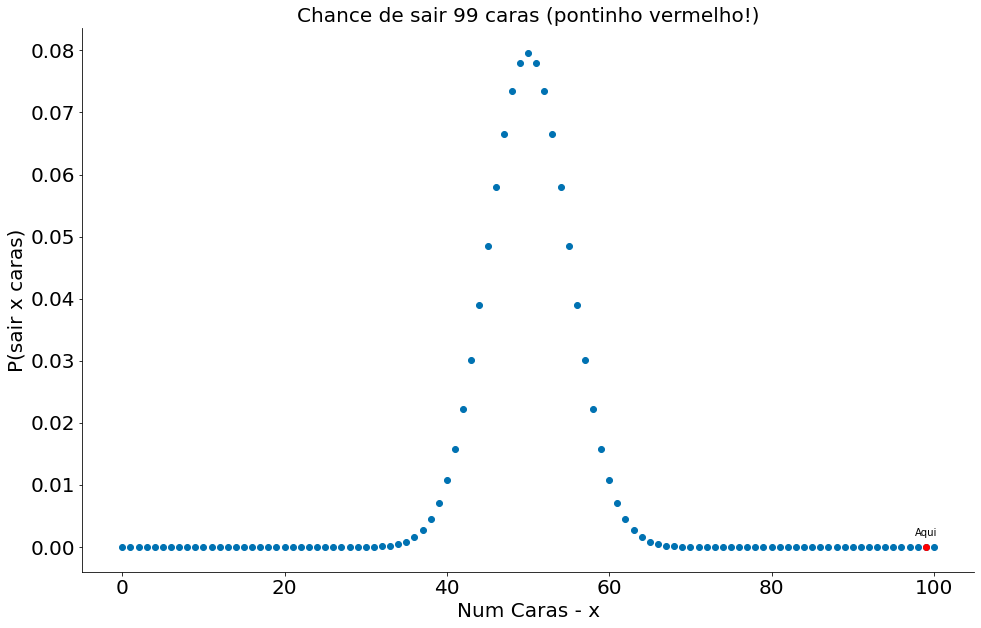

In [5]:
x = np.arange(0, 101) # Valores no eixo x
prob_binom = ss.distributions.binom.pmf(x, 100, 0.5)
plt.plot(x, prob_binom, 'o')
plt.plot([99], prob_binom[99], 'ro')
plt.text(99, 0.0018, 'Aqui', horizontalalignment='center')
plt.xlabel('Num Caras - x')
plt.ylabel('P(sair x caras)')
plt.title('Chance de sair 99 caras (pontinho vermelho!)')
despine()

Quase zero! Porém, é fácil falar de moedas. Foi assim também quando estudamos o IC. Vamos explorar outros casos.

## Exemplo 1: Juri no Alabama

__No início dos anos 1960, no Condado de Talladega, no Alabama, um negro chamado Robert Swain foi condenado por  à morte por estuprar uma mulher branca. Ele recorreu da sentença, citando entre outros fatores o júri todo branco. Na época, apenas homens com 21 anos ou mais eram autorizados a servir em júris no condado de Talladega. No condado, 26% dos jurados elegíveis eram negros. No juri final, havia apenas 8 negros entre os 100 selecionados para o painel de jurados no julgamento de Swain.__

Nossa pergunta: **Qual é a probabilidade (chance) de serem selecionados 8 indíviduos negros?**

Para nos ajudar com este exemplo, o código amostra proporções de uma população. O mesmo gera 10,000 amostras ($n$) de uma população de tamanho `pop_size`. Tais amostras são geradas sem reposição. Além do mais, o código assume que:

1. [0, $pop\_size * prop$) pertencem a um grupo.
1. [$pop\_size * prop$, $pop\_size$) pertencem a outro grupo.

Ou seja, em uma população de 10 (pop_size) pessoas. Caso a proporção seja 0.2 (prop). A população tem a seguinte cara:

__[G1, G1, G2, G2, G2, G2, G2, G2, G2, G2]__.

A ideia do cógido é responder: **Ao realizar amostras uniformes da população acima, quantas pessoas do tipo G1 e do tipo G2 são amostradas**. Para isto, realizamos 10,0000 amostras.

In [6]:
def sample_proportion(pop_size, prop, n=10000):
    '''
    Amostra proporções de uma população.
    
    Parâmetros
    ----------
    pop_size: int, tamanho da população
    prop: double, entre 0 e 1
    n: int, número de amostras
    '''
    assert(prop >= 0)
    assert(prop <= 1)
    
    grupo = pop_size * prop
    resultados = np.zeros(n)
    for i in range(n):
        sample = np.random.randint(0, pop_size, 100)
        resultados[i] = np.sum(sample < grupo)
    return resultados

Vamos ver agora qual é a cara de 10,000 amostras da cidade de Talladega. Vamos assumir que a cidade tem uma população de 100,000 habitantes. Tal número não importa muito para o exemplo, estamos olhando amostras. Podemos ajustar com a real.

O gráfico abaixo mostra no eixo-x o número de pessoas negras em cada amostra uniforme. Realizamos 10,000 delas. No eixo-y, a quantidade de amostras com aquele percentua. Agora responda, qual a chance de sair 8 pessoas apenas?

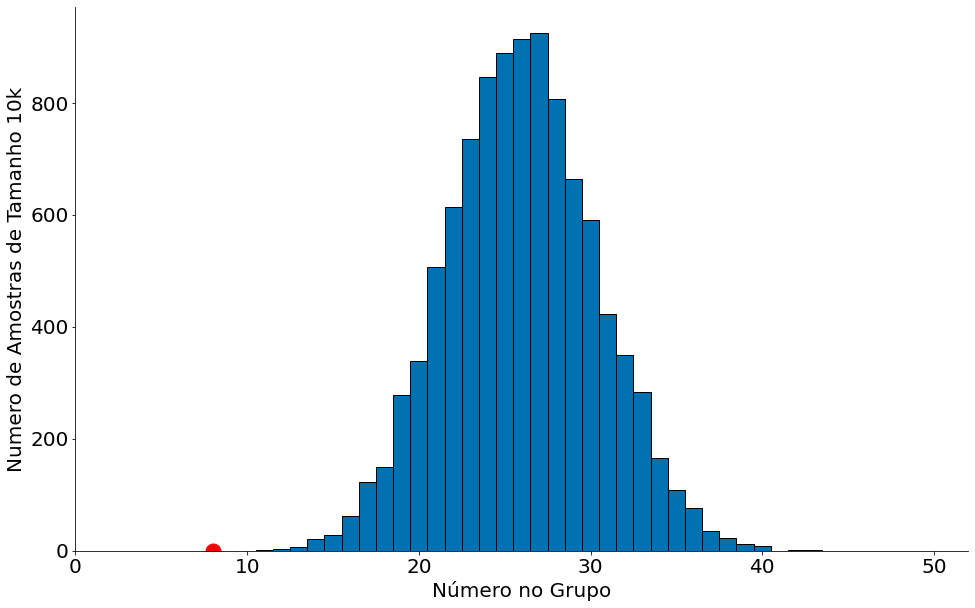

In [7]:
proporcoes = sample_proportion(pop_size=100000, prop=0.26)
bins = np.linspace(1, 100, 100) + 0.5
plt.hist(proporcoes, bins=bins, edgecolor='k')
plt.xlim(0, 52)
plt.ylabel('Numero de Amostras de Tamanho 10k')
plt.xlabel('Número no Grupo')
plt.plot([8], [0], 'ro', ms=15)
despine()

Podemos usar 5\% de chance para nos ajudar. É assim que funciona os testes. Com 5\% de chances, saiem pelo menos 19 pessoas negras. Então estamos abaixo disto, bem raro!

In [8]:
np.percentile(proporcoes, 5)

19.0

Este exemplo, assim como o próximo, embora não assuma nada sobre a população, assume uma hipótese nula de seleção uniforme. Isto é, qual é a probabilidade de ocorre o valor que observamos em uma seleção uniforme?!

## Ideia de Testes de Hipóteses

1. Dado um valor observado $t_{obs}.$
1. Qual é a chance deste valor em uma hipótese (modelo) nulo?!

No exemplo acima $t_{obs}=8$.

## Exemplo 2 -- Um outro Juri

In 2010, the American Civil Liberties Union (ACLU) of Northern California presented a report on jury selection in Alameda County, California. The report concluded that certain ethnic groups are underrepresented among jury panelists in Alameda County, and suggested some reforms of the process by which eligible jurors are assigned to panels. In this section, we will perform our own analysis of the data and examine some questions that arise as a result.

Aqui temos um outro exemplo de juri. Neste caso, temos diferentes grupos raciais. Como podemos falar algo dos grupos? Precisamos de uma estatística de teste. Portanto, vamos usar a __total variation distance__.

$$TVD(p, q) = \sum_{i=0}^{n-1} abs(p_i - q_i)$$

p e q aqui são vetores com proporções. Cada vetor deve somar 1. Quão maior a TVD, maior a diferença entre as proporções dos dois vetores! Quando p == q, temos TVD == 0.

In [9]:
def total_variation(p, q):
    '''
    Computa a total variation distance com base em dois vetore, p e q
    
    Parâmetros
    ----------
    p: vetor de probabilidades de tamanho n
    q: vetor de probabilidades de tamanho n
    '''
    return np.sum(np.abs(p - q)) / 2

Nossos dados. No juri, temos as seguintes proporções em cada raça.

In [10]:
idx = ['Asian', 'Black', 'Latino', 'White', 'Other']
df = pd.DataFrame(index=idx)
df['pop'] = [0.15, 0.18, 0.12, 0.54, 0.01]
df['sample'] = [0.26, 0.08, 0.08, 0.54, 0.04]
df

,pop,sample
Asian,0.15,0.26
Black,0.18,0.08
Latino,0.12,0.08
White,0.54,0.54
Other,0.01,0.04


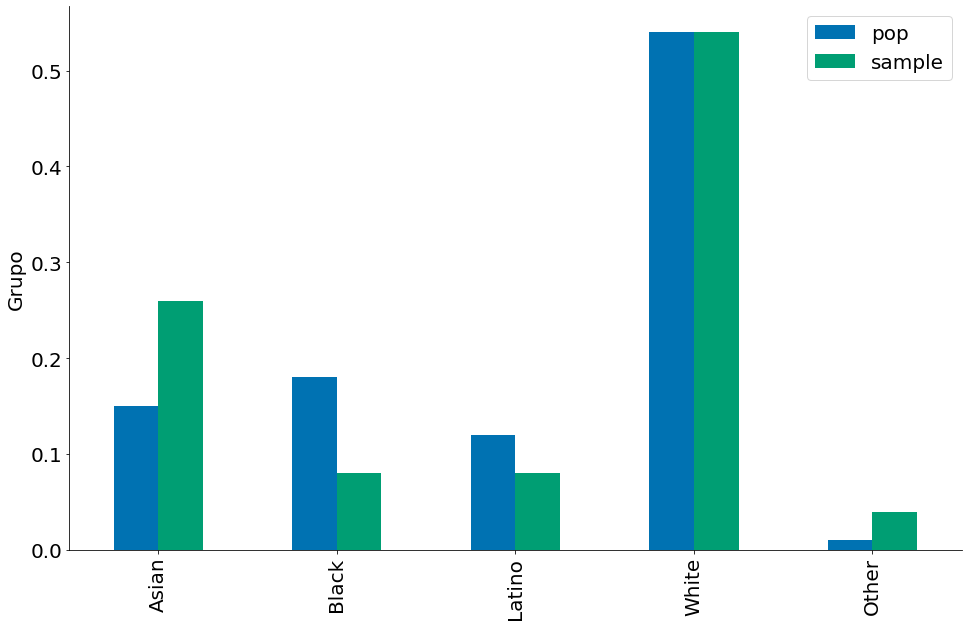

In [11]:
df.plot.bar()
plt.ylabel('Propopção')
plt.ylabel('Grupo')
despine()

Vamos comparar com uma amostra aleatória! Para isto, vou amostrar cada grupo por vez. Note a diferença.

In [12]:
N = 1453
uma_amostra = []
for g in df.index:
    p = df.loc[g]['pop']
    s = sample_proportion(N, p, 1)[0]
    uma_amostra.append(s/100)

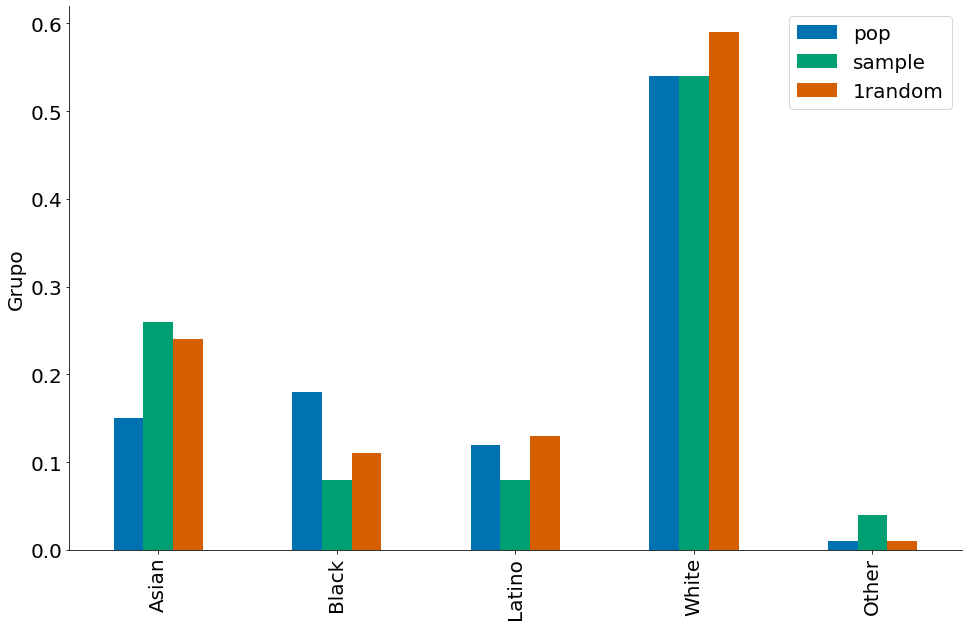

In [13]:
df['1random'] = uma_amostra
df.plot.bar()
plt.ylabel('Propopção')
plt.ylabel('Grupo')
despine()

Agora compare o TVD nos dados e na amostra aleatória!

In [14]:
total_variation(df['1random'], df['pop'])

0.10999999999999996

In [15]:
total_variation(df['sample'], df['pop'])

0.14

Para realizar o teste, fazemos 10,000 amostras e comparamos os TVDs! O código abaixo guarda o resultado de cada amostra em uma linha de uma matriz.

In [16]:
N = 1453
A = np.zeros(shape=(10000, len(df.index)))
for i, g in enumerate(df.index):
    p = df.loc[g]['pop']
    A[:, i] = sample_proportion(N, p) / 100

In [17]:
A

array([[0.2 , 0.21, 0.12, 0.6 , 0.02],
       [0.19, 0.23, 0.13, 0.5 , 0.02],
       [0.19, 0.18, 0.08, 0.54, 0.01],
       ...,
       [0.11, 0.15, 0.12, 0.49, 0.02],
       [0.08, 0.17, 0.09, 0.51, 0.01],
       [0.15, 0.12, 0.14, 0.53, 0.01]])

Agora o histograma da TVD. O  ponto vermelho mostra o valor que observamos, as barras mostram as diferentes amostras. Novamente, bastante raro tal valor. Rejeitamos a hipótese nula e indicamos que os dados não foram selecionados de forma uniforme!

In [18]:
all_distances = []
for i in range(A.shape[0]):
    all_distances.append(total_variation(df['pop'], A[i]))

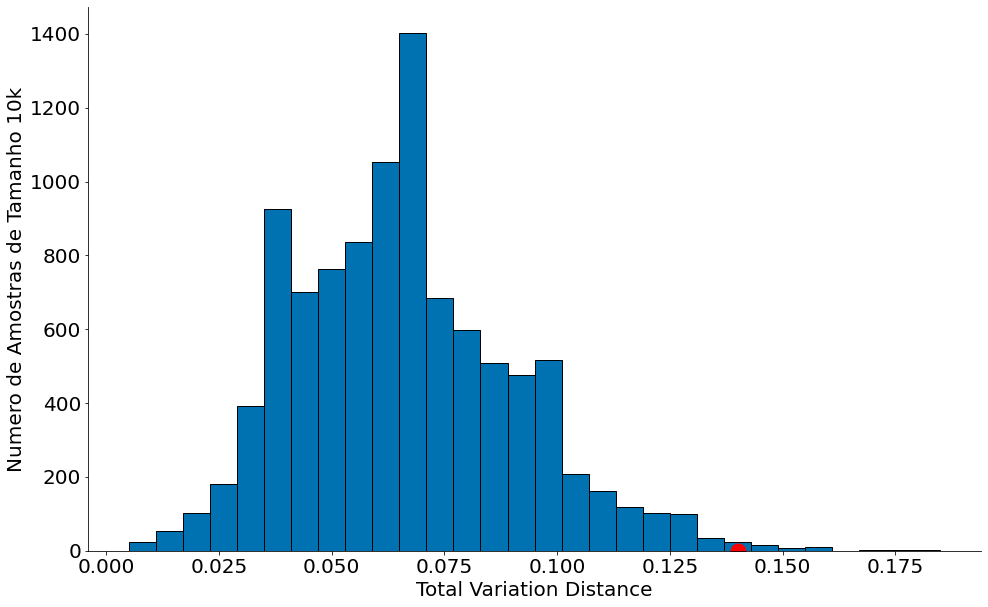

In [19]:
plt.hist(all_distances, bins=30, edgecolor='k')
plt.ylabel('Numero de Amostras de Tamanho 10k')
plt.xlabel('Total Variation Distance')
plt.plot([0.14], [0], 'ro', ms=15)
despine()

In [20]:
np.percentile(all_distances, 97.5)

0.12

## Caso 3. Dados Reais

Agora, finalmente vamos assumir um caso com dados reais. Em particular, vamos comparar salários de dois times da NBA. O dataframe se encontra abaixo. Vamos focar nos times:

1. Houston Rockets
1. Cleveland Cavaliers

Diferente do exemplo anterior, simular aqui vair ser um pouco mais complicado. É mais complicado assumir uma população para gerar amostras. Portanto vamos fazer uso de __testes de permutação__. Inicialmente, vamos explorar os dados (abaixo)

In [21]:
df = pd.read_csv('https://media.githubusercontent.com/media/icd-ufmg/material/master/aulas/11-Hipoteses/nba_salaries.csv')
df.head()

,PLAYER,POSITION,TEAM,SALARY
0,Paul Millsap,PF,Atlanta Hawks,18.671659
1,Al Horford,C,Atlanta Hawks,12.000000
2,Tiago Splitter,C,Atlanta Hawks,9.756250
3,Jeff Teague,PG,Atlanta Hawks,8.000000
4,Kyle Korver,SG,Atlanta Hawks,5.746479


In [22]:
df = df[df['TEAM'].isin(['Houston Rockets', 'Cleveland Cavaliers'])]
df.head()

,PLAYER,POSITION,TEAM,SALARY
72,LeBron James,SF,Cleveland Cavaliers,22.970500
73,Kevin Love,PF,Cleveland Cavaliers,19.689000
74,Kyrie Irving,PG,Cleveland Cavaliers,16.407501
75,Tristan Thompson,C,Cleveland Cavaliers,14.260870
76,Brendan Haywood,C,Cleveland Cavaliers,10.522500


Vamos pegar o salário médio de cada time. Observe que teremos uma diferença de mais ou menos 3 milhões e doláres. Tal estatística será a nossa $t_{obs}$. Antes disso, vamos criar um filtro (vetor de booleanos) para o Houston.

In [23]:
filtro = df['TEAM'] == 'Houston Rockets'

Agora o salário do Houston

In [24]:
filtro = df['TEAM'] == 'Houston Rockets'
df[filtro]['SALARY'].mean()

7.107153083333334

Do não Houston, ou seja, Cleveland.

In [25]:
df[~filtro]['SALARY'].mean()

10.231241200000001

Por fim, nossa estatística observada.

In [26]:
t_obs = df[~filtro]['SALARY'].mean() - df[filtro]['SALARY'].mean()
t_obs

3.124088116666667

## Teste de Permutação

Embora não estamos comparando proporções como nos exemplos anteriores, podemos sim brincar um pouco de simulação. Vamos assumir um seguinte modelo nulo. __A probabilidade de um jogador escolher (ou for contratado) em um time para jogar é igual para os dois times__. Ou seja, vamos dizer que a associação Jogador x Time é uniformimente aleatória! Como fazemos isto? Basta fazer um shuffle no filtro acima.

Assumindo apenas 5 jogadores. Os dados reais são:

1. Nomes:    [J1, J2, J3, J4, J5]
1. Salários: [S1, S2, S3, S4, S5]
1. Times:    [T1, T1, T2, T2, T2]

Vamos manter os nomes e os salários fixos. Ao fazer um shuffle (embaralhamento) nos times, temos:

1. Nomes:    [J1, J2, J3, J4, J5]
1. Salários: [S1, S2, S3, S4, S5]
1. Times:    [T1, T2, T2, T2, T1]

Esta é nossa hipótese nula! Vamos realizar uma!

In [27]:
np.random.shuffle(filtro.values)
diff = df[~filtro]['SALARY'].mean() - df[filtro]['SALARY'].mean()
diff

-4.786004916666667

Note acima que temos uma diferença de salários diferente do que observamos. Vamos agora gerar 10,000!

In [28]:
N = 10000
diferencas = np.zeros(N)
for i in range(N):
    np.random.shuffle(filtro.values)
    diff = df[~filtro]['SALARY'].mean() - df[filtro]['SALARY'].mean()
    diferencas[i] = diff

Na figura abaixo mostramos os resultados do mundo simulado. Note que em 16% dos casos temos diferença de salários mais extremas do que $t_{obs}$. Isto é uma chance bem alta! Nos exemplos anteriores tinhamos valores bem menores. Ou seja, **não rejeitamos a hipótese nula (modelo simulado)**. A variação dos salários pode ser explicado pelo acaso.

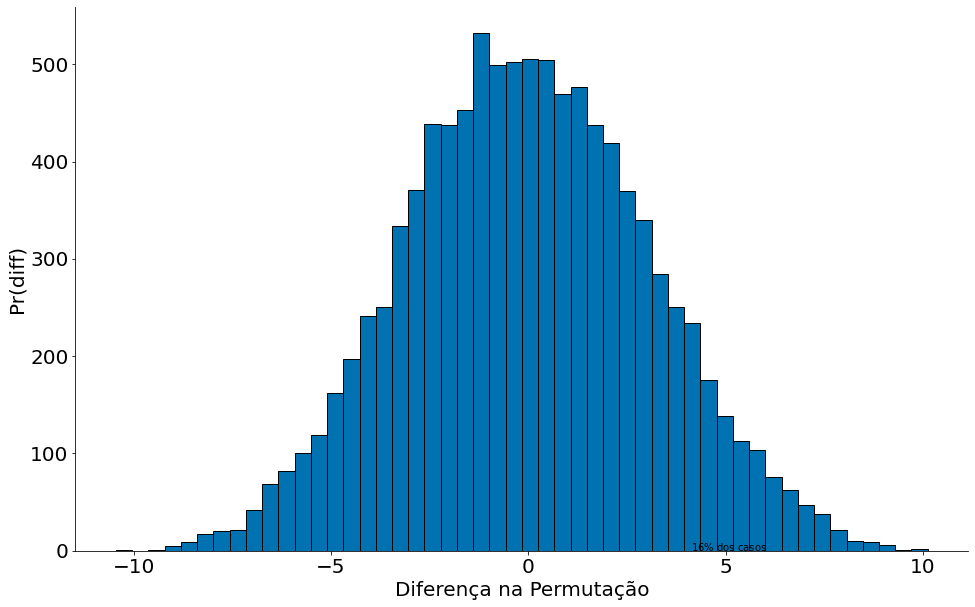

In [29]:
plt.hist(diferencas, bins=50, edgecolor='k')
plt.xlabel('Diferença na Permutação')
plt.ylabel('Pr(diff)')
plt.vlines(t_obs, 0, 0.14, color='red')
plt.text(t_obs+1, 0.10, '$16\%$ dos casos')
despine()
plt.show()

## Animação

In [30]:
from IPython.display import HTML
from matplotlib import animation

In [31]:
def update_hist(num, data):
    plt.cla()
    plt.hist(data[0:100 * (num+1)], bins=50,
             density=True, edgecolor='k')
    plt.xlabel('Diferença na Permutação')
    plt.ylabel('Pr(diff)')
    despine()

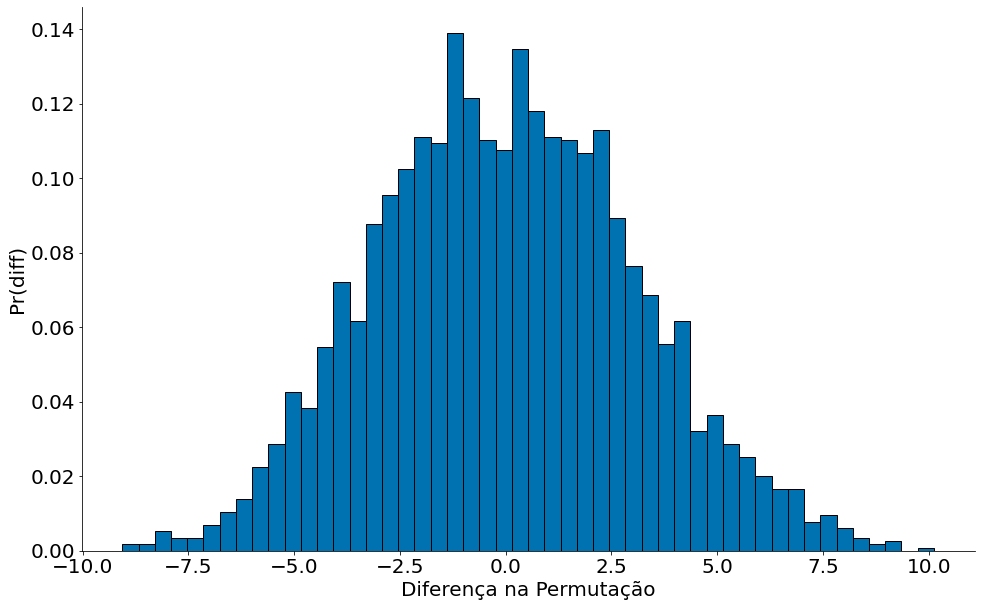

In [32]:
fig = plt.figure()
ani = animation.FuncAnimation(fig, update_hist, 30, fargs=(diferencas, ))
HTML(ani.to_html5_video())